# かがわAIゼミナール2019
## 課題2 : Car Fuel Consumption
## 100kmあたりのガソリン消費量(consume)を予測

#### DATA:kaggle    https://www.kaggle.com/anderas/car-consume

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数

In [2]:
# データ読み込み
df_data_csv = pd.read_csv("./car-consume/measurements.csv") 

display(df_data_csv.head())
df_data_csv.describe()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


,speed,temp_outside,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,41.927835,11.358247,0.077320,0.123711,0.082474
std,13.598524,6.991542,0.267443,0.329677,0.275441
min,14.000000,-5.000000,0.000000,0.000000,0.000000
25%,32.750000,7.000000,0.000000,0.000000,0.000000
50%,40.500000,10.000000,0.000000,0.000000,0.000000
75%,50.000000,16.000000,0.000000,0.000000,0.000000
max,90.000000,31.000000,1.000000,1.000000,1.000000


In [3]:
# distance : 距離km
# consume : 100kmあたりの消費リッター
# speed : 平均スピード
# temp_inside : エアコンの設定またはoffになっている場合は「Nan」
# temp_outside : 外気温
# specials : 雨、雪など気候変動がある場合は「AC」
# gas_type : 
# AC : one hot encoded, the special "AC". 1 for on, 0 for off
# rain : rain and snow is 1, good whather is 0

In [4]:
# データ型確認
df_data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
distance         388 non-null object
consume          388 non-null object
speed            388 non-null int64
temp_inside      376 non-null object
temp_outside     388 non-null int64
specials         93 non-null object
gas_type         388 non-null object
AC               388 non-null int64
rain             388 non-null int64
sun              388 non-null int64
refill liters    13 non-null object
refill gas       13 non-null object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


In [5]:
# 行列数確認
df_data_csv.shape

(388, 12)

### データの整理（前処理）

- 小数点の文字を','を '.'に変換
- 欠損値Nanチェック
- カテゴリ変数をダミー変数に変換　gas_type
- 外れ値チェック

In [6]:
# 小数点についてドイツ形式の","から"."に変換
# distance, consume, temp_inside
df_data_csv['distance'] = df_data_csv['distance'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['consume'] = df_data_csv['consume'].apply(lambda x: x.replace(",", ".")).astype(np.float)
df_data_csv['temp_inside'] = df_data_csv['temp_inside'].apply(lambda x: str(x).replace(",", ".")).astype(np.float)
df_data = df_data_csv
df_data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,E10,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,E10,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,E10,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,E10,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,E10,0,0,0,NaN,NaN


In [7]:
# 欠損値確認
print(df_data.isnull().sum())

distance           0
consume            0
speed              0
temp_inside       12
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64


temp_insideの欠損値を処理する

In [8]:
# nan削除し、中央値を計算

temp_inside_dropna = df_data['temp_inside'].dropna()
# 中央値
median_temp_inside = np.median(temp_inside_dropna)
# temp_insideのNanを中央値に置き換える
df_data["temp_inside"] = df_data["temp_inside"].fillna(median_temp_inside)
print(df_data.isnull().sum())

print('中央値 ： {:.3f}'.format(median_temp_inside))
print('平均値　：　{:.3f}'.format(np.mean(temp_inside_dropna)))
# temp_insideのNanを'0'に置き換える
# df_data["temp_inside"] = df_data["temp_inside"].fillna(0)

distance           0
consume            0
speed              0
temp_inside        0
temp_outside       0
specials         295
gas_type           0
AC                 0
rain               0
sun                0
refill liters    375
refill gas       375
dtype: int64
中央値 ： 22.000
平均値　：　21.930


In [9]:
# gas_typeを1:SP98, 0:E10 に変換
print(df_data['gas_type'].value_counts())

df_data['gas_type'] = np.where(df_data['gas_type'] == "SP98", 1, 0)

SP98    228
E10     160
Name: gas_type, dtype: int64


In [10]:
df_data.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28.0,5.0,26,21.5,12,NaN,0,0,0,0,45,E10
1,12.0,4.2,30,21.5,13,NaN,0,0,0,0,NaN,NaN
2,11.2,5.5,38,21.5,15,NaN,0,0,0,0,NaN,NaN
3,12.9,3.9,36,21.5,14,NaN,0,0,0,0,NaN,NaN
4,18.5,4.5,46,21.5,15,NaN,0,0,0,0,NaN,NaN


In [11]:
df_data.describe()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
count,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000,388.000000
mean,19.652835,4.912371,41.927835,21.931701,11.358247,0.587629,0.077320,0.123711,0.082474
std,22.667837,1.033172,13.598524,0.994741,6.991542,0.492897,0.267443,0.329677,0.275441
min,1.300000,3.300000,14.000000,19.000000,-5.000000,0.000000,0.000000,0.000000,0.000000
25%,11.800000,4.300000,32.750000,21.500000,7.000000,0.000000,0.000000,0.000000,0.000000
50%,14.600000,4.700000,40.500000,22.000000,10.000000,1.000000,0.000000,0.000000,0.000000
75%,19.000000,5.300000,50.000000,22.500000,16.000000,1.000000,0.000000,0.000000,0.000000
max,216.100000,12.200000,90.000000,25.500000,31.000000,1.000000,1.000000,1.000000,1.000000


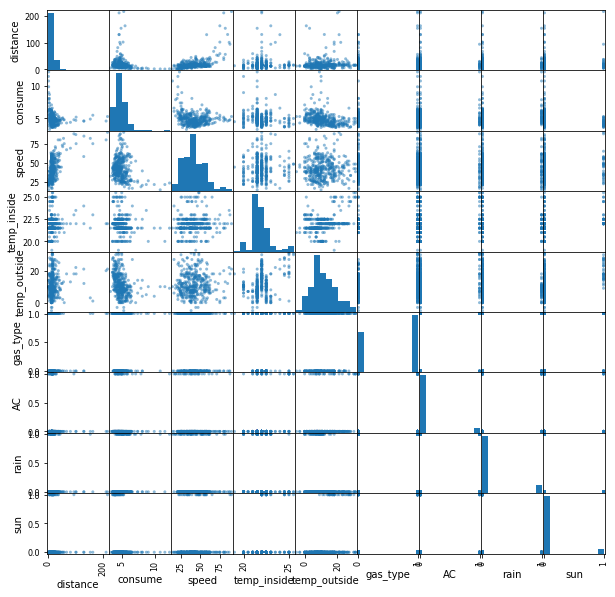

In [12]:
# 散布図行列
pd.plotting.scatter_matrix(df_data, figsize=(10,10))
plt.show()

In [13]:
# 相関係数を確認
df_data.corr()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
distance,1.000000,-0.128967,0.562299,0.074734,0.088175,-0.053411,-0.025738,-0.019791,0.081120
consume,-0.128967,1.000000,-0.227866,-0.161470,-0.320811,-0.015327,0.096591,0.248118,-0.170667
speed,0.562299,-0.227866,1.000000,0.059139,0.015411,-0.097360,-0.035408,0.009489,0.081618
temp_inside,0.074734,-0.161470,0.059139,1.000000,0.359649,0.010921,0.296719,-0.037204,0.242237
temp_outside,0.088175,-0.320811,0.015411,0.359649,1.000000,0.148705,0.167562,-0.186315,0.346903
gas_type,-0.053411,-0.015327,-0.097360,0.010921,0.148705,1.000000,0.105285,0.060328,0.022761
AC,-0.025738,0.096591,-0.035408,0.296719,0.167562,0.105285,1.000000,0.242915,0.088598
rain,-0.019791,0.248118,0.009489,-0.037204,-0.186315,0.060328,0.242915,1.000000,-0.112650
sun,0.081120,-0.170667,0.081618,0.242237,0.346903,0.022761,0.088598,-0.112650,1.000000


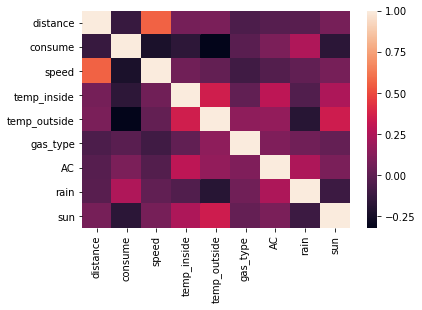

In [14]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_data.corr())
plt.show()

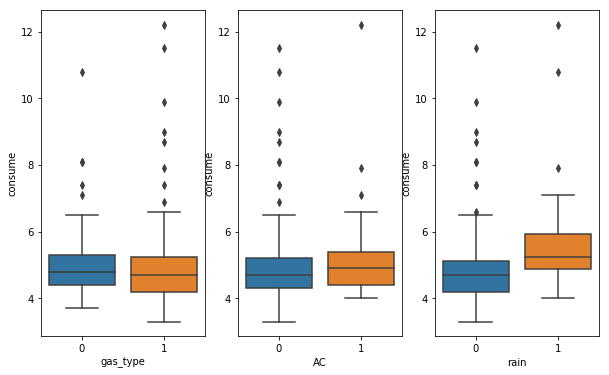

In [15]:
fig, ax = plt.subplots(1,3,figsize=(10,6))
sns.boxplot(x='gas_type', y='consume', data=df_data, ax=ax[0])
sns.boxplot(x='AC', y='consume', data=df_data, ax=ax[1])
sns.boxplot(x='rain', y='consume', data=df_data, ax=ax[2])

## 線形回帰モデルを使って学習

In [16]:
# consumeとの相関関係が大きいのはspeed, temp_outside, rain
# 係数を求める
y = df_data['consume'].values
X = df_data[['speed', 'temp_outside', 'rain']].values
# 線形回帰
regr = LinearRegression(fit_intercept=True)
regr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [17]:
# 重みを取り出す
w0 = regr.intercept_
w1 = regr.coef_[0]
w2 = regr.coef_[1]
w3 = regr.coef_[2]
# 変数の設定
# x1 = df_data_csv['speed']
# x2 = df_data_csv['temp_outside']
# x3 = df_data_csv['rain']
x1 = X[:,0]
x2 = X[:,1]
x3 = X[:,2]

In [18]:
# 重み確認
y_est = w0 + w1 * x1 + w2 * x2 + w3 * x3
print('w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}, w3 = {:.3f}'.format(w0, w1, w2, w3))

w0 = 6.024, w1 = -0.017, w2 = -0.041, w3 = 0.621


In [19]:
# MSE, RMSE, MAEの確認
# 値を予測
y_pred = regr.predict(X)

# 平均二乗誤差 MSEを計算
mse = mean_squared_error(y, y_pred) 
print("MSE = %s"%round(mse,3) )  

# 平方根平均二乗誤差 RMSEを計算
rmse = np.sqrt(mse)
print("RMSE = %s"%round(rmse, 3) )

# 絶対値誤差 MAEを計算
mae = mean_absolute_error(y, y_pred) 
print("MAE = %s"%round(mae,3) )

MSE = 0.862
RMSE = 0.928
MAE = 0.619


In [20]:
# MSE, RMSE, MAEを式でも確認
squared_error = 0.5 * np.sum((y - y_est) ** 2)
mean_squared_error_val = squared_error * 2 / len(y)
root_mean_squared_error_val = np.sqrt(mean_squared_error_val)
mean_absoluted_error_val = 0.5 * np.sum(abs(y - y_est)) * 2 / len(y)

print('MSE = {:.3f}'.format(mean_squared_error_val))
print('RMSE = {:.3f}'.format(root_mean_squared_error_val))
print('MAE = {:.3f}'.format(mean_absoluted_error_val))

MSE = 0.862
RMSE = 0.928
MAE = 0.619
